In [1]:
from functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

country_set = {'Australia', 'Canada', 'China, P.R.: Hong Kong', 'China, P.R.: Mainland', 'Denmark',
               'Finland', 'France', 'Germany', 'Indonesia', 'Ireland', 'Italy', 'Japan', 'Korea, Republic of',
               'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Singapore', 'Spain', 'Sweden', 'Thailand',
               'United Kingdom', 'United States', 'Taiwan Province of China'}
country_list = list(country_set)
country_list.sort()

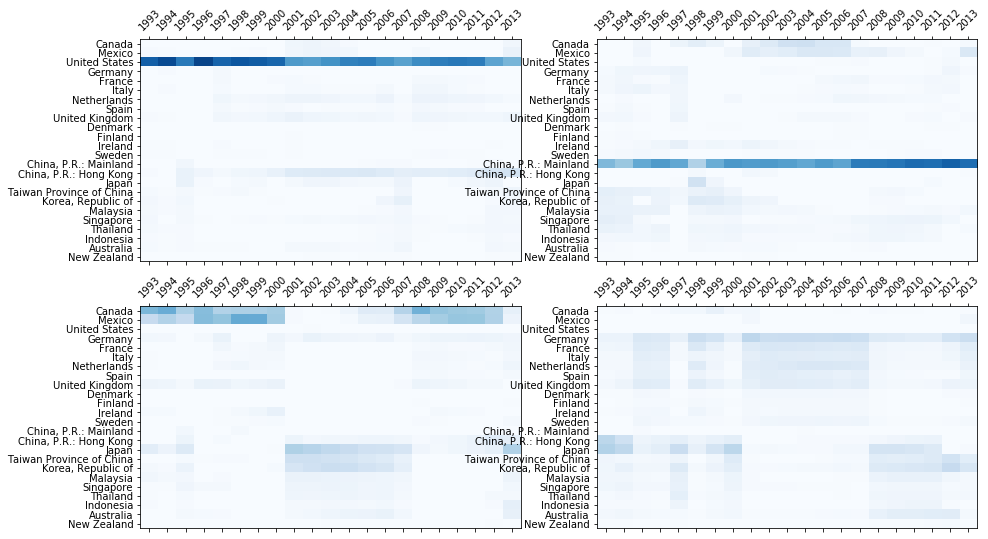

In [2]:
# Matrix-valued time series factorization reproduce.
with open('data\\TradeData.pickle', 'rb') as file:
    mm = pickle.load(file)
result = np.zeros((21, 24, 4))
result_list = []
for ii, year in enumerate(range(1991, 2012)):
    mmm = np.full([60, 24, 24], np.nan)
    for t, month in enumerate(mm.loc[str(year) + '-01':str(year + 4) + '-12', 0].index):
        mmm[t, :, :] = mm.loc[month, 0].values

    Q, D = factorize1(mmm, [1]) # There is a factorize2 where the left and right loading matrices are different

    # Rotation, truncate negative values, and normalization
    Q1, R = varimax(Q[:, 0:4])
    for i in range(Q1.shape[1]):
        if Q1[:, i].sum() < 0:
            Q1[:, i] = - Q1[:, i]

    Q1[Q1 < 0] = 0
    Q1 = Q1 / np.sum(Q1, axis=0)

    # Adjust the order of factors according to its weight in certain counties.
    # For better visualization purpose.
    classes = [0, 1, 2, 3]
    us = np.argmax(Q1[23, :])
    china = np.argmax(Q1[3, :])
    classes.remove(us)
    classes.remove(china)
    canada = np.argmax(np.sum(Q1[[1, 14,11]][:, classes], axis=0))
    canada = classes[canada]
    classes.remove(canada)
    rest = classes[0]
    Q2 = Q1[:, [us, china, canada, rest]]
    result[ii, :, :] = Q2


# Visualize results
order=[1,14,23,7,6,10,15,18,22,4,5,9,19,3,2,11,20,12,13,17,21,8,0,16]
fig, ax = plt.subplots(2, 2, figsize=(15,9))
ax[0, 0].matshow(result[:, order, 0].T, aspect='auto', cmap='Blues', vmin=0, vmax=1)
ax[0, 1].matshow(result[:, order, 1].T, aspect='auto', cmap='Blues', vmin=0, vmax=1)
ax[1, 0].matshow(result[:, order, 2].T, aspect='auto', cmap='Blues', vmin=0, vmax=1)
ax[1, 1].matshow(result[:, order, 3].T, aspect='auto', cmap='Blues', vmin=0, vmax=1)

for axi in ax.ravel():
    axi.set_xticks(range(0,21))
    axi.set_xticklabels(range(1993,2014),rotation=45)
    axi.set_yticks(range(24))
    axi.set_yticklabels([country_list[i] for i in order])